In [1]:
# Imports
import os, sys
import numpy as np
import ROOT as rt
import uproot
import h5py
import matplotlib.pyplot as plt
import root_numpy as rtnp
import pandas
from math import log10, floor
import math
from subprocess import Popen
import shlex 
import cmsstyle

Welcome to JupyROOT 6.12/07


In [2]:
inpath = '/eos/user/b/bmaier/www/case/results/20220609/'
qcd_file     = 'sig_MCOrig_QR_Reco.h5'
signal_file  = 'WkkToWRadionToWWW_M3000_Mr170Reco.h5'

xsecs   = [0]
mX = 3.
width = "Na"

In [3]:
# Rescaling the inputs to lumi. THESE VALUES NEED TO BE DOUBLE CHECKED WITH TOBIAS/OZ!

qcd_xsec       = 8730000.0 # Crossection in fb             
# qcd_gen_events = 134366091.0+199435365.0+90490645.0+134264102.0 #(all generated QCD. Not valid for CASE)
sig_xsec       = 10. #In units of fb (10 fb == 0.01 pb) 
sig_gen_events = 30000 #(all generated signal, check with Tobias!)
# lumi           = qcd_gen_events/qcd_xsec # assuming 64/fb since qcd_gen_events/8730000 ~ 64
lumi = 26.81 # lumi for new CASE blackbox dataset
# scale_qcd = qcd_xsec*lumi/qcd_gen_events

scale_qcd = 1.
scale_sig = 0.8*sig_xsec*lumi/sig_gen_events #20% already used for quantile regression, this might be different in Benedikts setup

print('Usign luminosity {}'.format(lumi))
print('Scale QCD with {}'.format(scale_qcd))
print('Scale signal with {}'.format(scale_sig))

Usign luminosity 26.81
Scale QCD with 1.0
Scale signal with 0.00714933333333


In [4]:
# Set binning
useDijet = True

# Dijet variable-binwidth binning (depends on dijet resolution)
if useDijet:
    bin_edges = np.array([#1200, 1255, 1320, 1387, 1457, 1529,
                          1457, 1529,
                          1604, 1681, 1761, 1844, 1930, 2019, 
                          2111, 2206, 2305, 2406, 2512, 2620, 
                          2733, 2849, 2969, 3093, 3221, 3353,
                          3490, 3632, 3778, 3928, 4084, 4245, 
                          4411, 4583, 4760, 4943, 5132, 5327]).astype('float') #Let's keep a reduced range for now..
                          #5574, 5737, 5951, 6173, 6402, 6638, 6882]).astype('float')
else:
    bin_edges = np.array(np.arange(1200.,5500., 100.).tolist()).astype('float') #100 GeV binning. Stop at 5600! Fit fails if going to 6800


n_bins = len(bin_edges)-1
max_bin = bin_edges[-1]
min_bin = bin_edges[0]
bws = (max_bin-min_bin)/n_bins

# Use an example file to find which column belongs to which orthogonal quantile cut and to mjj/dEta
path = inpath
columns   = {}


with h5py.File(path+qcd_file, 'r') as f_qcd:
    
        # Use the following quantile as control region
        cr_column = int(np.where(f_qcd['eventFeatureNames'][()] == 'sel_q70')[0])
        
        # Different quantiles (not orthogonal!)
#         columns[0.9]  = int(np.where(f_qcd['eventFeatureNames'][()] == 'sel_q90')[0]) # 0=rejected 1=accepted
        columns[0.7]  = int(np.where(f_qcd['eventFeatureNames'][()] == 'sel_q70')[0])
        columns[0.5]  = int(np.where(f_qcd['eventFeatureNames'][()] == 'sel_q50')[0])
        columns[0.3]  = int(np.where(f_qcd['eventFeatureNames'][()] == 'sel_q30')[0])
        columns[0.1]  = int(np.where(f_qcd['eventFeatureNames'][()] == 'sel_q10')[0])
        columns[0.01] = int(np.where(f_qcd['eventFeatureNames'][()] == 'sel_q01')[0])
        
        mjj_idx  = int(np.where(f_qcd['eventFeatureNames'][()] == 'mJJ')[0])
        deta_idx = int(np.where(f_qcd['eventFeatureNames'][()] == 'DeltaEtaJJ')[0])
        
print(columns)        

{0.5: 22, 0.7: 21, 0.3: 23, 0.01: 25, 0.1: 24}


In [5]:
# Create datasets (skip down to make workspace if you've already created histogram file!)

datas_qcd = {}
datas_sig = {}

datas_qcd_rejected = {}
datas_sig_rejected = {}


for xs in xsecs:

    path = inpath
    with h5py.File(path+qcd_file, 'r') as f_qcd:

        # Get all features as numpy arrays and apply dEta cut
        qcd_tot = np.array(f_qcd.get("eventFeatures"))
        qcd_tot = qcd_tot[abs(qcd_tot[:,deta_idx]) < 1.40]
        qcd = np.copy(qcd_tot)
        datas_qcd_acc = {}
   
        #Define the main templates as the 'unused quantile' at 70-100% background efficiency
        datas_qcd_acc[1.0] = qcd_tot[qcd_tot[:,cr_column] == 0]
        datas_qcd_acc[1.0] = datas_qcd_acc[1.0][:,mjj_idx]
        
        # DEFINE ORTHOGONAL QUANTILES
        for key in sorted(columns.keys()):
            
            # Start with q=0.01 and take all events that pass cut on VAE
            datas_qcd_acc[key] = qcd[qcd[:,columns[key]] == 1]
            datas_qcd_acc[key] = datas_qcd_acc[key][:,mjj_idx]
            
            #Remove those events from dataset and continue to next quantile
            qcd = qcd[qcd[:,columns[key]] == 0]
        
        datas_qcd[xs] = datas_qcd_acc
        

    # Open signal, repeat    
    with h5py.File(path+signal_file, 'r') as f_sig:
        
        sig_tot = np.array(f_sig.get("eventFeatures"))
        sig_tot = sig_tot[abs(sig_tot[:,deta_idx]) < 1.40]
    
    sig = np.copy(sig_tot)
    
    # Use everything above q0.7 as control region!
    datas_sig_acc = {}
    datas_sig_acc[1.0] = sig_tot[sig_tot[:,cr_column] == 0]
    datas_sig_acc[1.0] = datas_sig_acc[1.0][:,mjj_idx]
    
    for key in sorted(columns.keys()):
        
        datas_sig_acc[key] = sig[sig[:,columns[key]] == 1]
        datas_sig_acc[key] = datas_sig_acc[key][:,mjj_idx]

        sig = sig[sig[:,columns[key]] == 0]

    datas_sig[xs] = datas_sig_acc
    

/afs/cern.ch/user/t/thaarres/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1333: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/afs/cern.ch/user/t/thaarres/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1333: UserWarning: findfont: Font family [u'TeX Gyre Heros'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


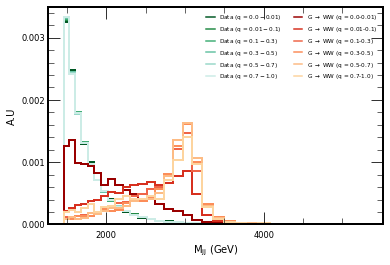

In [6]:
#Some quick control plots to check the shapes

#Color styles for signal and backgorund histograms
scol = ['#fdd49e','#fdbb84','#fc8d59','#ef6548','#d7301f','#990000'] *3
scol.reverse()
bcol = ['#ccece6','#99d8c9','#66c2a4','#41ae76','#238b45','#005824'] *3
bcol.reverse()

from matplotlib.lines import Line2D
import cmsstyle
fig, ax = plt.subplots()

for i,key in enumerate(sorted(datas_qcd_acc.keys())):
    if i > 0:
        lower_bound = sorted(datas_qcd_acc.keys())[i-1]
    else:
       lower_bound = 0.0 
    plt.hist(datas_qcd_acc[key],bins=bin_edges,label=r'Data (q = ${}-{}$)'.format(lower_bound,key),histtype='step', linewidth=2, facecolor='none', edgecolor=bcol[i],fill=True,density=True)
      
for i,key in enumerate(sorted(datas_sig_acc.keys())):
    if i > 0:
        lower_bound = sorted(datas_sig_acc.keys())[i-1]
    else:
       lower_bound = 0.0 
    plt.hist(datas_sig_acc[key],bins=bin_edges,label=r'G $\rightarrow$ WW (q = {}-{})'.format(lower_bound,key),histtype='step', linewidth=2, facecolor='none', edgecolor=scol[i],fill=True,density=True)
    
handles, labels = ax.get_legend_handles_labels()
new_handles = [Line2D([], [], c=h.get_edgecolor(),linestyle=h.get_linestyle()) for h in handles]
plt.ylabel('A.U')
plt.xlabel(u'$M_{jj}$ (GeV)')
plt.locator_params(nbins=4)
plt.legend(handles=new_handles, labels=labels,loc='best',frameon=False, ncol=2,fontsize='xx-small')
#plt.savefig('signal_shapes_nolog_{}.pdf'.format(signal))

In [7]:
# Fill lumiscaled histograms and set some cosmetics

scaled_histos_qcd = {}
scaled_histos_data = {}
scaled_histos_signal = {}
    
for ii,xs in enumerate(xsecs):
    
    print("\nxs = {}:".format(xs))
    
    datas_qcd_acc = datas_qcd[xs]  
    datas_sig_acc = datas_sig[xs] 
    
    histos_qcd = {}
    histos_data = {}
    histos_signal = {}
    histos_signal_pd = {}

    
    axis_title = ['M_{jj}','Events']
    scol =['#fc9272','#de2d26','#fee0d2']*2
    bcol =['#3182bd','#9ecae1','#deebf7']*2
    
    for i,(keyD,keyS) in enumerate(zip( sorted(datas_qcd_acc.keys()), sorted(datas_sig_acc.keys()) )):
        
        print("q = {}:".format(keyD))
            
        histos_qcd[keyD]  = rt.TH1D('data_obs_{}'.format(keyD),'',n_bins,bin_edges.astype('float'))
        histos_signal[keyS]= rt.TH1D('signal_{}'  .format(keyS),'',n_bins,bin_edges.astype('float'))

        rtnp.fill_hist(histos_qcd[keyD]   , datas_qcd_acc[keyD], weights=None)
        rtnp.fill_hist(histos_signal[keyS] , datas_sig_acc[keyS], weights=None)

        # Scale signal by the crossection injected (default is 10 fb)
        if xs == 0:
            scale = 1.
        else:
            scale = xs/10.
        histos_signal[keyS].Scale(scale_sig*scale)
        histos_qcd[keyD]  .SetStats(0)
        histos_signal[keyS].SetStats(0)

        histos_qcd[keyD].Sumw2()
        histos_signal[keyS].Sumw2()
        
        histos_qcd[keyD].SetXTitle(axis_title[0])
        histos_qcd[keyD].SetYTitle(axis_title[1])
        histos_qcd[keyD].binning = bin_edges

        histos_signal[keyS].SetXTitle(axis_title[0])
        histos_signal[keyS].SetYTitle(axis_title[1])
        histos_signal[keyS].binning = bin_edges

        histos_qcd[keyD].SetLineColor(rt.TColor.GetColor(bcol[ii]))
        histos_qcd[keyD].SetMarkerColor(rt.TColor.GetColor(bcol[ii]))
        histos_qcd[keyD].SetLineStyle(1)
        histos_qcd[keyD].SetLineWidth(2)
        
        histos_signal[keyS].SetLineColor(rt.TColor.GetColor(scol[ii]))
        histos_signal[keyS].SetLineStyle(1)
        histos_signal[keyS].SetLineWidth(2)
        histos_signal[keyS].SetFillColorAlpha((rt.TColor.GetColor(scol[ii])), 0.30)

        
        histos_qcd[keyD].SetMarkerStyle(20)
        histos_qcd[keyD].SetMarkerSize(0.9)
        
        #Define signal Mjj window as 20% of each side of MX. Only used for drawing purposes and S/sqrt(B) values
        axis = histos_qcd[keyD].GetXaxis()
        bmin = axis.FindBin(mX*1000*0.8)
        bmax  = axis.FindBin(mX*1000*1.2)
        mjjmin = axis.GetBinCenter(bmin)
        mjjmax = axis.GetBinCenter(bmax)
                
        NQCD       = int(histos_qcd[keyD].Integral())
        NSIG       = int(histos_signal[keyS].Integral())
        SB         = NSIG/(NQCD**0.5)
        
        NQCD_SLICE = int(histos_qcd[keyD].Integral(bmin,bmax))
        NSIG_SLICE = int(histos_signal[keyS].Integral(bmin,bmax))
        SB_SLICE   = NSIG_SLICE/(NQCD_SLICE**0.5)
        
       
        print("N_SIG = {} N_BKG = {}".format(NSIG,NQCD))
        print("S/sqrt(B)={} For mX+-20%: S/sqrt(B)={}".format(SB,SB_SLICE))
        print("")

        
        NQCD       = int(histos_qcd[keyD].Integral())
        NSIG       = int(histos_signal[keyS].Integral())
        SB         = NSIG/np.sqrt(NQCD)
        

        # Make the pseudodataset with signal+data if signal xsec !=0
        histos_data[keyD] = histos_qcd[keyD].Clone('data_{}_{}'.format(xs,keyD))
        if xs != 0:
            histos_data[keyD].Add(histos_signal[keyS])# Add weighted signal shape

        histos_data[keyD].SetBinErrorOption(rt.TH1.kPoisson)
        
        print("Integrals: QCD = {} Signal = {} Pseudodata = {}".format(histos_qcd[keyD].Integral(),histos_signal[keyS].Integral(),histos_data[keyD].Integral()))
        print("")
                                  
    
    scaled_histos_data[xs]   = histos_data
    scaled_histos_qcd[xs]    = histos_qcd
    scaled_histos_signal[xs] = histos_signal   
     


xs = 0:
q = 0.01:
N_SIG = 13 N_BKG = 28922
S/sqrt(B)=0.0764414983904 For mX+-20%: S/sqrt(B)=0.0712068994916

Integrals: QCD = 28922.0 Signal = 13.1619226667 Pseudodata = 28922.0

q = 0.1:
N_SIG = 123 N_BKG = 259802
S/sqrt(B)=0.241314748951 For mX+-20%: S/sqrt(B)=0.63386348031

Integrals: QCD = 259802.0 Signal = 123.912245333 Pseudodata = 259802.0

q = 0.3:
N_SIG = 93 N_BKG = 582166
S/sqrt(B)=0.121887601077 For mX+-20%: S/sqrt(B)=0.397276078852

Integrals: QCD = 582166.0 Signal = 93.0986186667 Pseudodata = 582166.0

q = 0.5:
N_SIG = 34 N_BKG = 580791
S/sqrt(B)=0.0446137755578 For mX+-20%: S/sqrt(B)=0.149255342917

Integrals: QCD = 580791.0 Signal = 34.659968 Pseudodata = 580791.0

q = 0.7:
N_SIG = 17 N_BKG = 572738
S/sqrt(B)=0.0224631637016 For mX+-20%: S/sqrt(B)=0.0746913686973

Integrals: QCD = 572738.0 Signal = 17.973424 Pseudodata = 572738.0

q = 1.0:
N_SIG = 12 N_BKG = 870391
S/sqrt(B)=0.0128624603853 For mX+-20%: S/sqrt(B)=0.0388882294957

Integrals: QCD = 870391.0 Signal = 12.83

Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created


In [8]:
import cmsstyle #mplhep for Python2 cheatsheet

def drawHistos(qPass,qFail,scaled_histos_data,scaled_histos_signal, xsecs):
    c_out = rt.TCanvas("ratio_qacc{}_qrej{}".format(qPass,qFail), "", 1000, 1000)
    pad1 = rt.TPad("pad1_qacc{}_qrej{}".format(qPass,qFail), "pad1_qacc{}_qrej{}".format(qPass,qFail), 0, 0.3, 1, 1.0)
    pad1.SetBottomMargin(0.001)
    pad1.SetLeftMargin(0.13)
    # pad1.SetGridx()
    pad1.Draw()
    pad1.cd()
    leg = rt.TLegend(0.22, 0.6, 0.89, 0.90)
    leg.SetNColumns(2)
    leg.SetTextSize(0.045)
    leg.SetBorderSize(0)
    leg.SetFillStyle(0)

#     scaled_histos_data_rej[0][qFail].Draw('PEZ')
#     scaled_histos_data_rej[10][qFail].Draw('PEZsame')
#     scaled_histos_data_rej[100][qFail].Draw('PEZsame')

    scaled_histos_data[xsecs[0]][qFail].Draw('HIST')
    for xs in xsecs:
        scaled_histos_data[xs][qFail].Draw('HISTsame')
        scaled_histos_data[xs][qPass].Draw('PEZsame')
        scaled_histos_signal[xs][qPass].Draw('HISTsame')


    scaled_histos_data[xsecs[0]][qFail].SetTitle("")
    scaled_histos_data[xsecs[0]][qFail].SetMinimum(0.9)
    scaled_histos_data[xsecs[0]][qFail].GetYaxis().SetTitleSize(0.05)
    scaled_histos_data[xsecs[0]][qFail].GetYaxis().SetLabelSize(0.05)
    scaled_histos_data[xsecs[0]][qFail].GetYaxis().SetTitleOffset(0.95)
    scaled_histos_data[xsecs[0]][qFail].SetMaximum(qcd_tot.shape[0]*1.2)
    scaled_histos_data[xsecs[0]][qFail].GetYaxis().SetNdivisions(304)
    
    for xs in xsecs:
        leg.AddEntry(scaled_histos_data[xs][qPass] , 'Inj. {} fb:     Data q = {}'.format(int(xs),qPass), 'lep') 
        leg.AddEntry(scaled_histos_data[xs][qFail] , 'q = {}'.format('0.7-1.0'), 'l')
        leg.AddEntry(scaled_histos_signal[xs][0.1] , 'G(#sigma = {} fb)'.format(int(xs)), 'l') 


    leg.Draw('same')

    pad1.SetLogy()
    pad1.SetTitle('')
    pad1.Update()
    c_out.cd()
    pad2 = rt.TPad("pad2_qacc{}_qrej{}".format(qPass,qFail), "pad2_qacc{}_qrej{}".format(qPass,qFail), 0, 0, 1, 0.3)
    pad2.SetTopMargin(0.00)
    pad2.SetBottomMargin(0.27)
    pad2.SetLeftMargin(0.13)
    # pad2.SetGrid()
    pad2.Draw()
    pad2.cd()
    data_hist_ratio = {}
    tline = {}
    for xs in xsecs:
        data_hist_ratio[xs] = scaled_histos_data[xs][qPass].Clone('data_hist_ratio_{}'.format(i))
        data_hist_ratio[xs].Divide( scaled_histos_data[xs][qFail])
    #     data_hist_ratio[xs].Scale( scaled_histos_data_rej[xs][qFail].Integral()/scaled_histos_data[xs][qPass].Integral())
        data_hist_ratio[xs].binning = bin_edges
        if xs == 0:
            data_hist_ratio[xs].SetTitle('')
            data_hist_ratio[xs].Draw('pez')
            eff = scaled_histos_data[xs][qPass].Integral()/scaled_histos_data[xs][qFail].Integral()
            data_hist_ratio[xs].SetMaximum(eff*1.5)
            data_hist_ratio[xs].SetMinimum(eff*0.5)
#             data_hist_ratio[xs].SetYTitle('#frac{#epsilon#timesq}{q_{0.9-1.0}}')
            data_hist_ratio[xs].SetYTitle('#frac{Acc.}{Rej.}')
            data_hist_ratio[xs].GetYaxis().CenterTitle()
            data_hist_ratio[xs].SetXTitle('M_{jj} (GeV)')
            data_hist_ratio[xs].GetYaxis().SetTitleOffset(0.4)
            data_hist_ratio[xs].GetYaxis().SetTitleSize(0.12)
            data_hist_ratio[xs].GetYaxis().SetLabelSize(0.12)
            data_hist_ratio[xs].GetYaxis().SetNdivisions(304)
            data_hist_ratio[xs].GetXaxis().SetNdivisions(909)
            data_hist_ratio[xs].GetXaxis().SetTitleOffset(0.95)
            data_hist_ratio[xs].GetXaxis().SetTitleSize(0.12)
            data_hist_ratio[xs].GetXaxis().SetLabelSize(0.12)
            data_hist_ratio[xs].GetXaxis().SetTickSize(0.07)
        else:
            data_hist_ratio[xs].Draw('pez same')


    #     tline[key] = rt.TLine(min_bin, (key-lower_bound)/0.1, max_bin, (key-lower_bound)/0.1)
        
        tline[xs] = rt.TLine(min_bin, eff, max_bin, eff)
        tline[xs].SetLineColor(rt.kBlack)
        tline[xs].SetLineStyle(rt.kDashed)
        tline[xs].Draw('same')
    pad2.Update()
    c_out.Update()
    #c_out.SaveAs("mjj_q{}.pdf".format(qPass))
    return c_out, leg, tline[0], data_hist_ratio

Warning in <TCanvas::Constructor>: Deleting canvas with same name: ratio_qacc0.01_qrej1.0
Warning in <TCanvas::Constructor>: Deleting canvas with same name: ratio_qacc0.1_qrej1.0
Warning in <TCanvas::Constructor>: Deleting canvas with same name: ratio_qacc0.3_qrej1.0
Warning in <TCanvas::Constructor>: Deleting canvas with same name: ratio_qacc0.5_qrej1.0
Warning in <TCanvas::Constructor>: Deleting canvas with same name: ratio_qacc0.7_qrej1.0


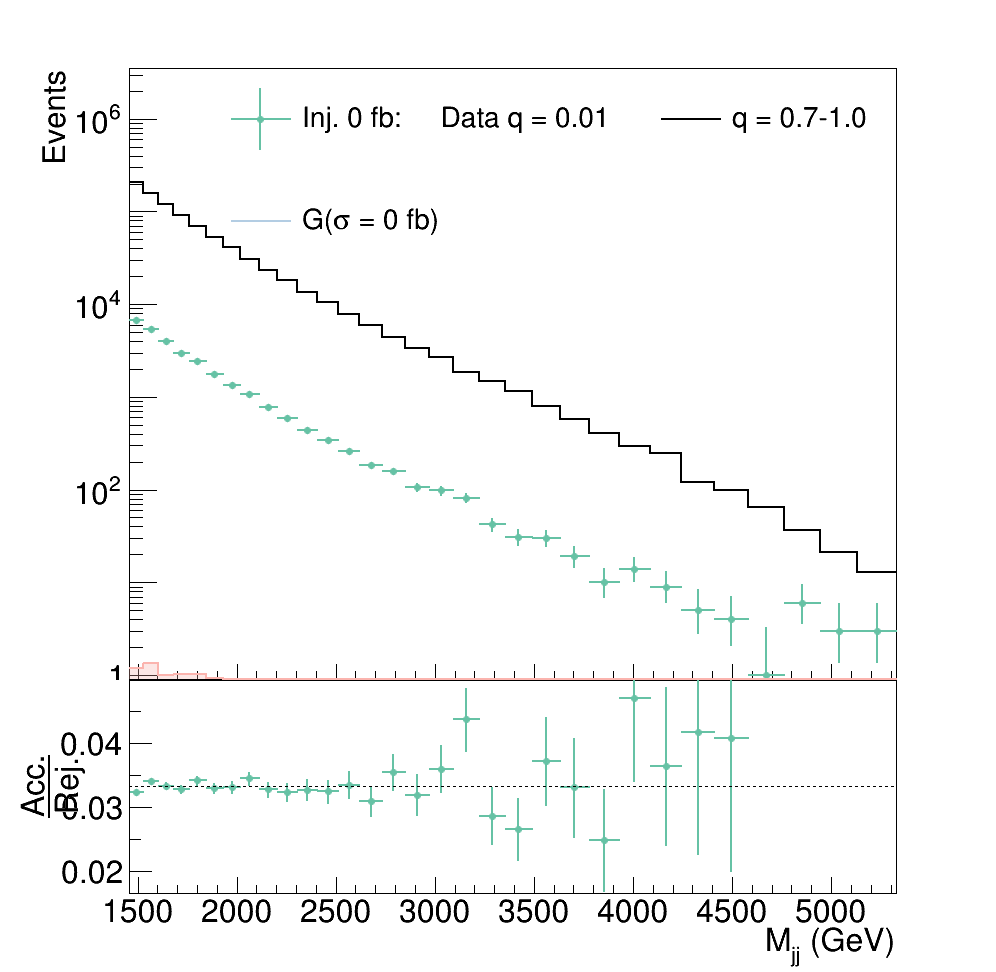

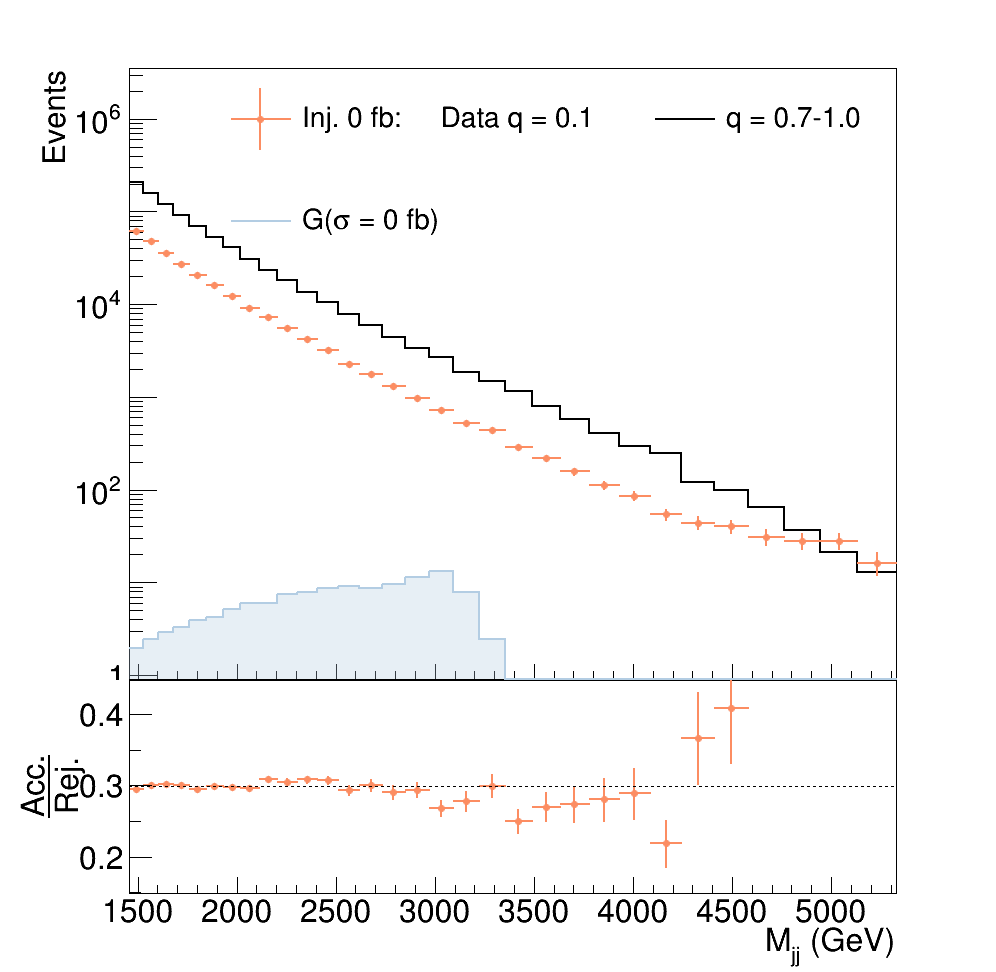

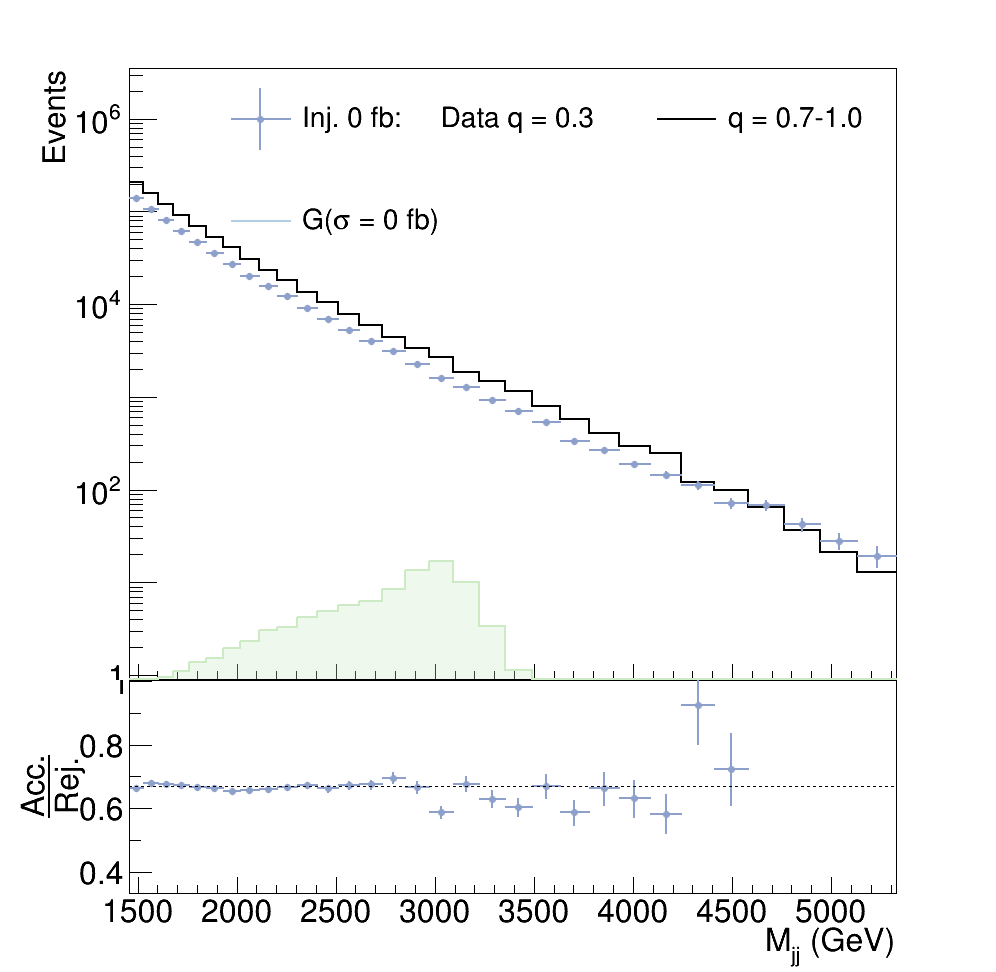

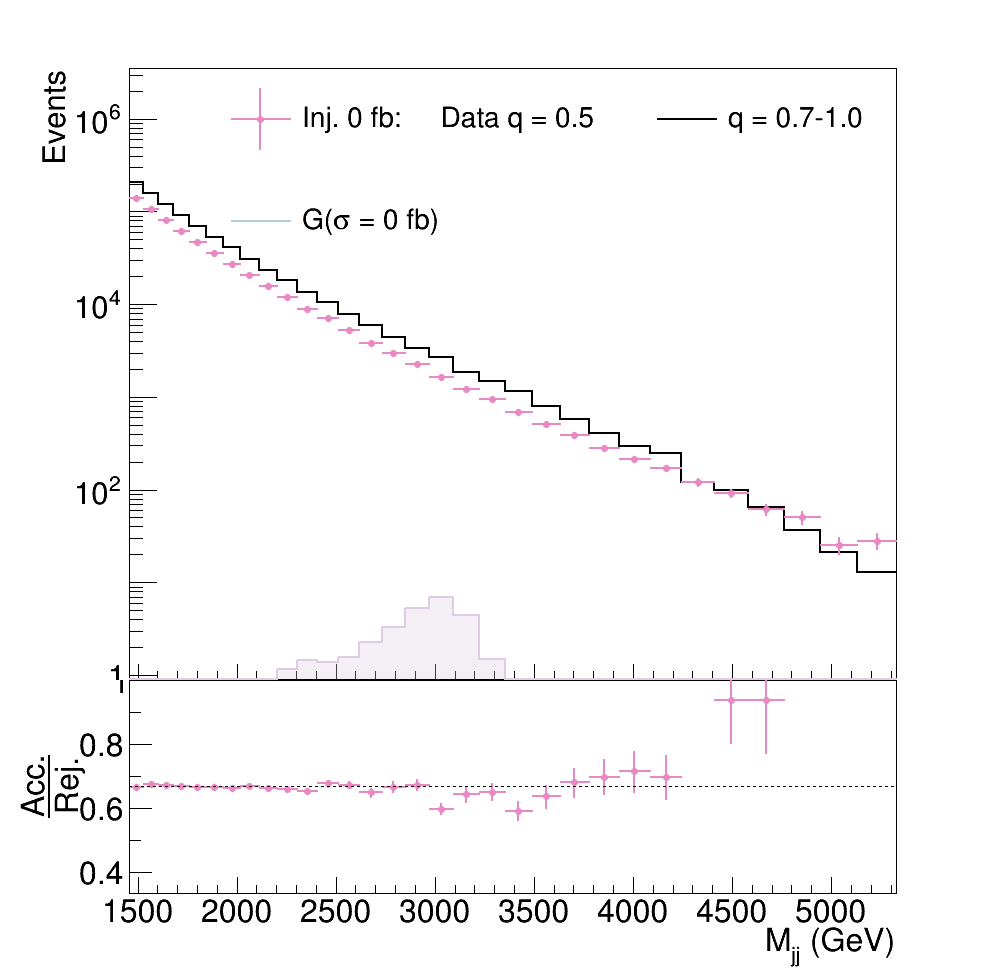

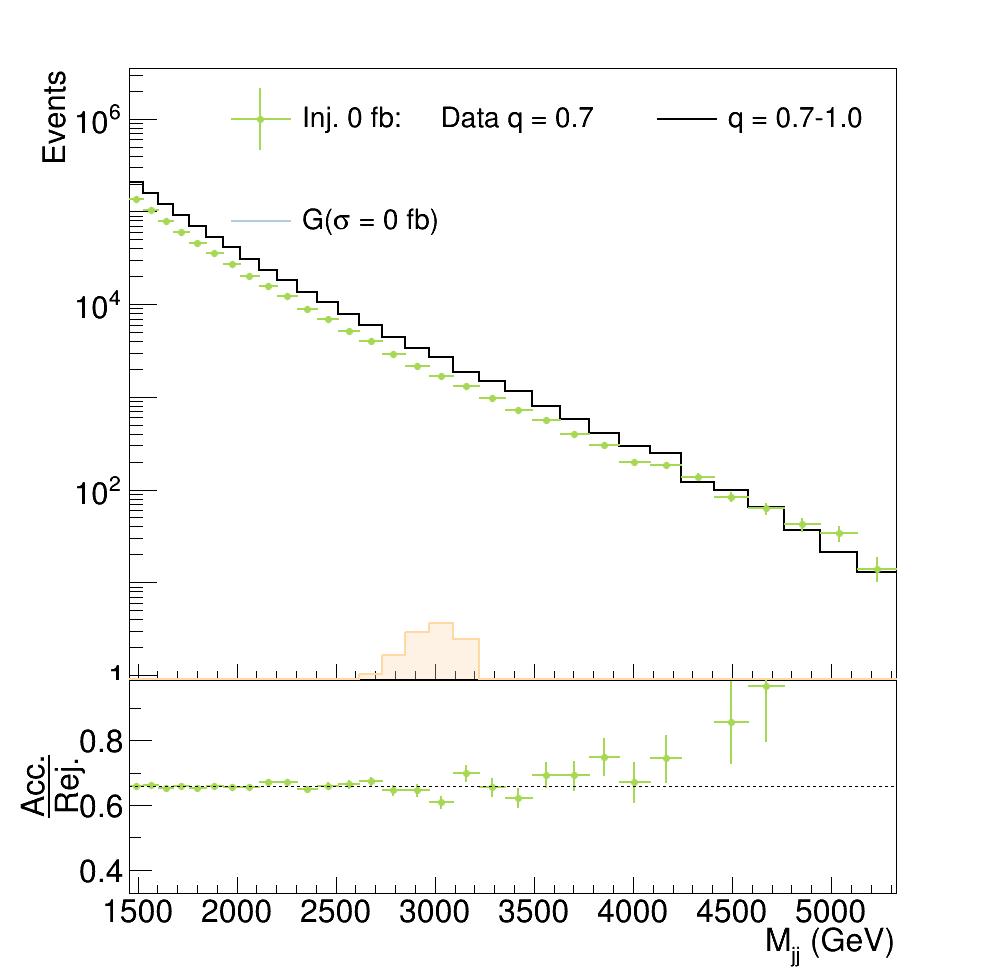

In [14]:
# If the plits down show, execute this cell twice (gotta love root)
canvs = []
c0,l0,t0,h0 = drawHistos(0.01,1.0,scaled_histos_data,scaled_histos_signal,xsecs); canvs.append([c0,l0,t0,h0]);canvs[0][0].Draw()
c1,l1,t1,h1 = drawHistos(0.1 ,1.0,scaled_histos_data,scaled_histos_signal,xsecs) ; canvs.append([c1,l1,t1,h1]);canvs[1][0].Draw()
c2,l2,t2,h2 = drawHistos(0.3 ,1.0,scaled_histos_data,scaled_histos_signal,xsecs) ; canvs.append([c2,l2,t2,h2]);canvs[2][0].Draw()
c3,l3,t3,h3 = drawHistos(0.5 ,1.0,scaled_histos_data,scaled_histos_signal,xsecs) ; canvs.append([c3,l3,t3,h3]);canvs[3][0].Draw()
c4,l4,t4,h4 = drawHistos(0.7 ,1.0,scaled_histos_data,scaled_histos_signal,xsecs) ; canvs.append([c4,l4,t4,h4]);canvs[4][0].Draw()
#c5,l5,t5,h5 = drawHistos(0.9 ,1.0,scaled_histos_data,scaled_histos_signal,xsecs) ; canvs.append([c5,l5,t5,h5]);canvs[5][0].Draw()

0.7
1.5197018532
1
0.5
1.49863031624
0.3
1.49509074731
0.1
3.35020900532
0.01
30.0944263882
0.01
0.1
0.3
0.5
0.7


Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created


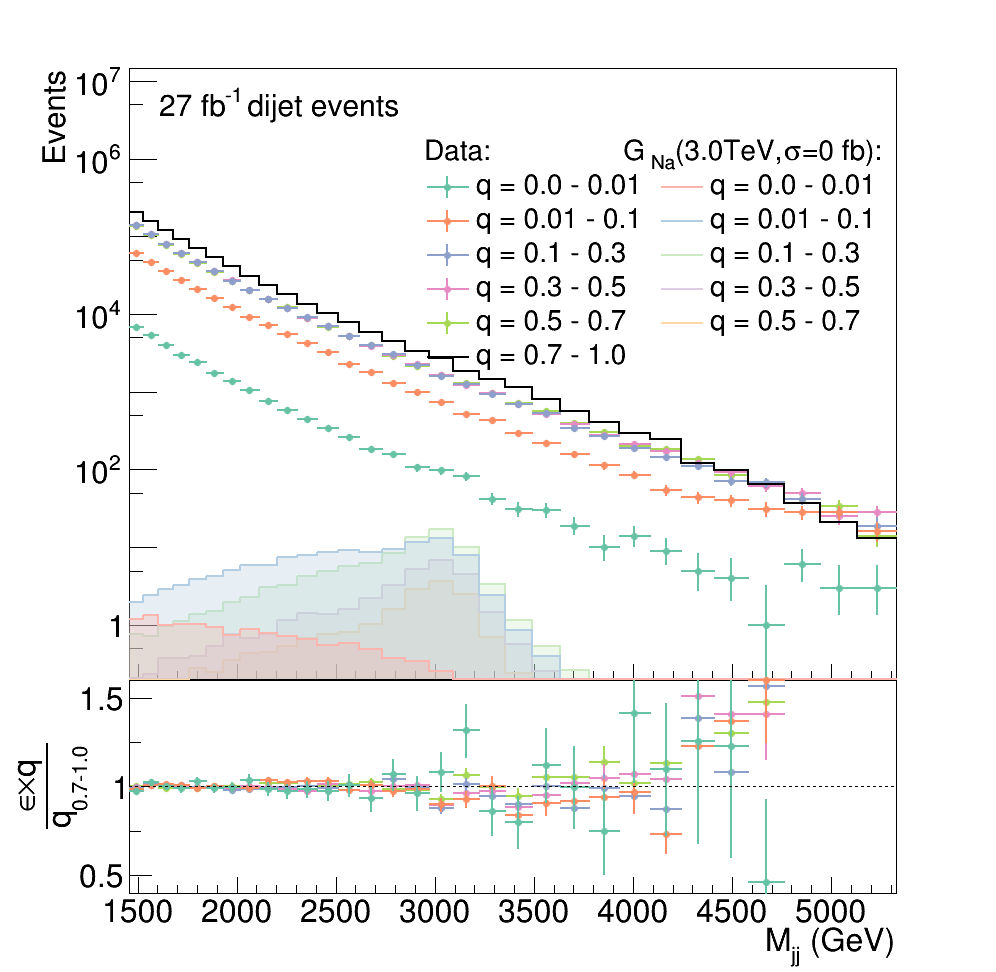

In [10]:
# Draw "nice" ratio plot for paper, check efficiency quantile/template and smoothness

xs = 0
import cmsstyle #mplhep for Python2 cheatsheet
#Color style
scol = ['#fbb4ae','#b3cde3','#ccebc5','#decbe4','#fed9a6','#ffffcc'] *3
scol.reverse()
bcol = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3','#a6d854','#ffd92f'] *3
bcol.reverse()

c_out = rt.TCanvas("ratio", "", 1000, 1000)
pad1 = rt.TPad("pad1", "pad1", 0, 0.3, 1, 1.0)
pad1.SetBottomMargin(0.001)
pad1.SetLeftMargin(0.13)
# pad1.SetGridx()
pad1.Draw()
pad1.cd()
leg = rt.TLegend(0.42, 0.45, 0.89, 0.80)
leg.SetNColumns(2)
leg.SetTextSize(0.045)
leg.SetBorderSize(0)
leg.SetFillStyle(0)
scaled_histos_data[xs][1.0].SetLineColor(rt.kBlack)
scaled_histos_data[xs][1.0].SetMarkerColor(rt.kBlack)
scaled_histos_data[xs][1.0].Draw('HIST')
scaled_histos_data[xs][1.0].SetTitle("")
scaled_histos_data[xs][1.0].SetMinimum(0.2)
scaled_histos_data[xs][1.0].GetYaxis().SetTitleSize(0.05)
scaled_histos_data[xs][1.0].GetYaxis().SetLabelSize(0.05)
scaled_histos_data[xs][1.0].GetYaxis().SetTitleOffset(0.95)
scaled_histos_data[xs][1.0].SetMaximum(qcd_tot.shape[0]*5.0)
scaled_histos_data[xs][1.0].GetYaxis().SetNdivisions(304)

leg.SetHeader('Data:                 G_{%s}(%.1fTeV,#sigma=%i fb):'%(width[:2],mX,xs))

for i,key in enumerate(sorted(scaled_histos_data[0].keys(), reverse=True)):
    if key == 1.0:
        continue
    scaled_histos_data[xs][key].SetLineColor(rt.TColor.GetColor(bcol[i]))
    scaled_histos_data[xs][key].SetMarkerColor(rt.TColor.GetColor(bcol[i]))
    scaled_histos_data[xs][key].Draw('pez same')
    scaled_histos_signal[xs][key].SetLineColor(rt.TColor.GetColor(scol[i]))
    scaled_histos_signal[xs][key].SetFillColorAlpha((rt.TColor.GetColor(scol[i])), 0.30)
    scaled_histos_signal[xs][key].Draw('HIST same')
for i,key in enumerate(sorted(scaled_histos_data[0].keys(), reverse=False)):
    if key == 1.0:
        continue
    elif i > 0:
        lower_bound = sorted(scaled_histos_data[xs].keys())[i-1]
    else:
       lower_bound = 0.0 
    leg.AddEntry(scaled_histos_data[xs][key]  , 'q = {} - {}'.format(lower_bound,key), 'lep')
    leg.AddEntry(scaled_histos_signal[xs][key], 'q = {} - {}'.format(lower_bound,key), 'l')    
scaled_histos_data[xs][1.0].Draw('same HIST')
# histos_signal_full[0.1].Draw('HIST same')
# histos_signal_full[0.01].Draw('HIST same')
# leg.SetTextSize(0.04)  
leg.AddEntry(scaled_histos_data[xs][1.0] , 'q = 0.7 - 1.0', 'l') 
leg.Draw('same')

pad1.SetLogy()
pad1.SetTitle('')

c_out.cd()
pad2 = rt.TPad("pad2", "pad2", 0, 0, 1, 0.3)
pad2.SetTopMargin(0.00)
pad2.SetBottomMargin(0.27)
pad2.SetLeftMargin(0.13)
# pad2.SetGrid()
pad2.Draw()
pad2.cd()
data_hist_ratio = {}
tline = {}
for i,key in enumerate((sorted(scaled_histos_data[xs].keys(),reverse=True))):
    if key == 1.0:
        continue
    pad2.cd()
    if i > 0:
        lower_bound = sorted(scaled_histos_data[xs].keys())[i-1]
    else:
        lower_bound = 0.0 
    scaled_histos_data[0][key].Sumw2()
    data_hist_ratio[key] = scaled_histos_data[xs][key].Clone('data_hist_ratio_{}'.format(i))
    scaled_histos_data[0][1.0].Sumw2()
    data_hist_ratio[key].Divide(scaled_histos_data[xs][1.0])
    data_hist_ratio[key].Scale(scaled_histos_data[xs][1.0].Integral()/scaled_histos_data[xs][key].Integral())
    print(key)
    print(scaled_histos_data[xs][1.0].Integral()/scaled_histos_data[xs][key].Integral())
    data_hist_ratio[key].binning = bin_edges
    if i == 1:
        print(i)
        data_hist_ratio[key].SetTitle('')
        data_hist_ratio[key].Draw('pez')
        data_hist_ratio[key].SetMaximum(1.6)
        data_hist_ratio[key].SetMinimum(0.4)
        data_hist_ratio[key].SetYTitle('#frac{#epsilon#timesq}{q_{0.7-1.0}}')

        data_hist_ratio[key].GetYaxis().CenterTitle()
        data_hist_ratio[key].SetXTitle('M_{jj} (GeV)')
        data_hist_ratio[key].GetYaxis().SetTitleOffset(0.4)
        data_hist_ratio[key].GetYaxis().SetTitleSize(0.12)
        data_hist_ratio[key].GetYaxis().SetLabelSize(0.12)
        data_hist_ratio[key].GetYaxis().SetNdivisions(304)
        data_hist_ratio[key].GetXaxis().SetNdivisions(909)
        data_hist_ratio[key].GetXaxis().SetTitleOffset(0.95)
        data_hist_ratio[key].GetXaxis().SetTitleSize(0.12)
        data_hist_ratio[key].GetXaxis().SetLabelSize(0.12)
        data_hist_ratio[key].GetXaxis().SetTickSize(0.07)
    else:
        data_hist_ratio[key].Draw('pez same')
    
    tline[key] = rt.TLine(min_bin, 1.0, max_bin, 1.0)
    tline[key].SetLineColor(rt.kBlack)
    tline[key].SetLineStyle(rt.kDashed)
    tline[key].Draw('same')
for i,key in enumerate(sorted(data_hist_ratio.keys())):
    print(key)
# sig_hist_ratio = signal_hist_acc.Clone('signal_hist_ratio')
# sig_hist_ratio.SetTitle('')
# sig_hist_ratio.Sumw2()
# sig_hist_ratio.Divide(signal_hist_rej)
# sig_hist_ratio.binning = bin_edges
# data_hist_ratio.Scale(data_hist_rej.Integral()/data_hist_acc.Integral())

# sig_hist_ratio.Draw('pez same')
c_out.cd()
latex = rt.TLatex()
latex.SetNDC ()
latex.SetTextSize (0.033)
latex.SetTextFont( 42 )
latex.DrawLatex (0.16 ,0.88 , "%.0f fb^{-1} dijet events"%lumi)
if xs != 0:
    latex.SetTextSize (0.03)
    latex.SetTextFont( 42 )
    latex.DrawLatex(0.16 ,0.83 , "Inj. {} fb @ 3.5 TeV".format(int(xs)))
# latex.DrawLatex(0.17 ,0.83 , "#Delta#eta_{jj} < 1.3, M_{jj} > 1.2 TeV")
# latex.DrawLatex(0.17 ,0.79 , "p_{T} > 200 GeV, |#eta| < 2.5")
c_out.Update()
c_out.Draw()
# c_out.SaveAs('mjj_all_inj{}fb_{}.pdf'.format(int(xs),signal))

In [11]:
# Save all the histograms to file (will be imported to workspace below)

outfile = rt.TFile("histograms.root", 'RECREATE' )

for xs in xsecs:
    # Save the data and signal "control region" histograms
    scaled_histos_signal[xs][1.0].Write('signal_rej_{}fb_q{}p'.format(xs,100))   
    scaled_histos_data[xs][1.0].Write('data_rej_{}fb_q{}p'.format(xs,100))
    # Then for each quantile
    for key in sorted(columns.keys()):
        quantile = int(key*100)
        scaled_histos_signal[xs][key].Write('signal_acc_{}fb_q{}p'.format(xs,quantile))
        scaled_histos_data[xs][key].Write('data_acc_{}fb_q{}p'.format(xs,quantile))

outfile.Close() 

\begin{tabular}{lrrrrrrr}
\toprule
          q & $\sigma$ [fb] & $N_{bkg}$ & $N_{sig}$ & $S/\sqrt{B}$ & $N_{bkg}$ ($M_{X} \pm 10\%$) & $N_{sig}$ ($M_{X} \pm 10\%$) & $S/\sqrt{B}$ ($M_{X} \pm 10\%$) \\
\midrule
 0.0 - 0.01 &            10 &     28922 &        13 &         0.08 &                         1775 &                            3 &                            0.07 \\
 0.0 - 0.01 &            20 &     28922 &        26 &         0.20 &                         1775 &                            6 &                            0.10 \\
 0.0 - 0.01 &            40 &     28922 &        52 &         0.30 &                         1775 &                           13 &                            0.30 \\
 0.0 - 0.01 &            60 &     28922 &        78 &         0.50 &                         1775 &                           20 &                            0.50 \\
 0.0 - 0.01 &            80 &     28922 &       105 &         0.60 &                         1775 &                           

Warning in <TCanvas::Constructor>: Deleting canvas with same name: ratio
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already

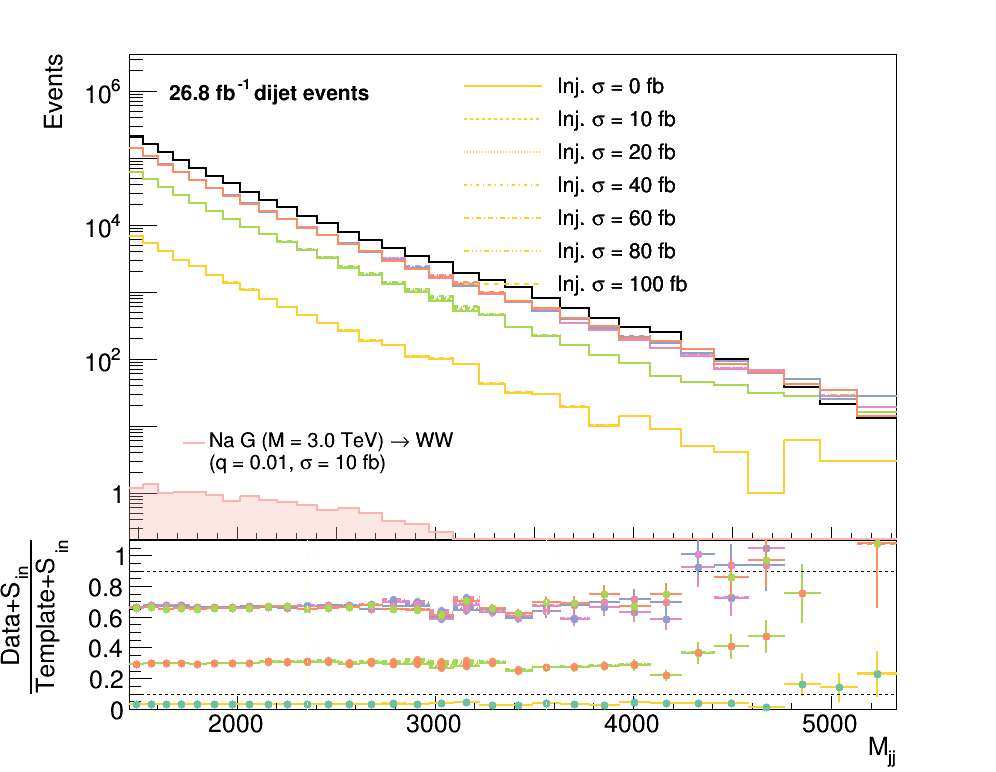

In [12]:
# THIS IS ONLY IF YOU WANT TO INJECT SIGNALS WHICH ARE DIFFERENT THAN THOSE USED FOR THE QR TRAINING.
# This is an approximation, and only valid if we prove QR is independent from injected signal

# --> ARE YOU SURE YOU WANT TO RUN THIS?

sig_inj_vals = [0,1,2,4,6,8,10]
MX = mX*1000 #Signal mass in units of GeV

data = {'q':[],'q_string':[],'sig_inj':[],'mjjmin':[],  'mjjmax':[], 'NQCD':[], 'NSIG':[],'SB':[],'NQCD_SLICE':[], 'NSIG_SLICE':[],'SB_SLICE':[]}
        
# These dictionaries will contain the 70-100% quantile with injected signal (data_hist_rej_inj_all)
# and the orthogonal quantiles with injected signal (data_hist_acc_inj_all). They will be saved to 'histfile'
# The format is data_hist_rej_inj_all[quantile][sig_injected]

data_hist_acc_inj_all = {}
signal_hist_acc_inj_all = {}

#Define signal Mjj window as 20% of each side of MX. Only used for drawing purposes and S/sqrt(B) values
axis = scaled_histos_data[0][1.0].GetXaxis()
bmin = axis.FindBin(MX*0.8)
bmax  = axis.FindBin(MX*1.2)
mjjmin = axis.GetBinCenter(bmin)
mjjmax = axis.GetBinCenter(bmax)

# Helper function to round numbers for TeX table
def round_sig(x, sig=1):
    if x == 0.:
        return 0
    else:
        return round(x, sig-int(floor(log10(abs(x))))-1)


leg = rt.TLegend(0.48, 0.5, 0.89, 0.85)
#stick to no injecion for now
c_out = rt.TCanvas("ratio", "", 1000, 800)
pad1 = rt.TPad("pad1", "pad1", 0, 0.3, 1, 1.0)
pad1.SetBottomMargin(0.001)
pad1.SetLeftMargin(0.13)
pad1.SetLogy()
pad1.SetTitle('')
pad1.Draw()
pad1.cd()
leg = rt.TLegend(0.45, 0.61, 0.89, 0.91)
# leg.SetNColumns(2)
leg.SetTextSize(0.05)
leg.SetBorderSize(0)
leg.SetFillStyle(0)
leg.SetTextSize (0.03)
leg.SetTextFont( 62 )
# leg.SetHeader('SR (#forall q):                  CR (q = 0.9 - 1.0):')
leg.SetTextSize (0.03)
leg.SetTextFont( 42 )
scaled_histos_data[0][1.0].Draw('HIST')
scaled_histos_signal[0][0.01].Draw('HISTsame')
scaled_histos_data[0][1.0].SetTitle("")
scaled_histos_data[0][1.0].SetMinimum(0.2)
scaled_histos_data[0][1.0].SetMaximum(qcd_tot.shape[0]*1.2)
scaled_histos_data[0][1.0].GetYaxis().SetLabelSize(0.05)
scaled_histos_data[0][1.0].GetYaxis().SetTitleSize(0.05)


for i,key in enumerate(sorted(scaled_histos_data[0].keys())):
    if i > 0:
        lower_bound = sorted(scaled_histos_data[0].keys())[i-1]
    else:
        lower_bound = 0.0 
    prefix = 'q'+str(int(key*100))

    data_hist_acc_inj = {}
    signal_hist_acc_inj = {}

    for k,sig_inj in enumerate(sig_inj_vals):
        data_hist_acc_inj[sig_inj] = scaled_histos_data[0][key].Clone('data_hist_acc_inj{}_{}'.format(sig_inj,prefix))
        signal_hist_acc_inj[sig_inj] = scaled_histos_signal[0][key].Clone('signal_inj{}_{}'.format(sig_inj,prefix))
        tmpSig = scaled_histos_signal[0][key].Clone('tmp_signal_inj{}_{}'.format(sig_inj,prefix))
        
        # Scale signal by the crossection injected (default is 10 fb)
        if xs == 0:
            scale = 1.
        else:
            scale = xs/10.
        signal_hist_acc_inj[sig_inj].Scale(sig_inj)
        
        data_hist_acc_inj[sig_inj].Sumw2()
        signal_hist_acc_inj[sig_inj].Sumw2()
    
        # Make the pseudodataset with signal+data. 
        if sig_inj != 0:
            data_hist_acc_inj[sig_inj].Add(signal_hist_acc_inj[sig_inj])

        signal_hist_acc_inj[sig_inj].SetBinErrorOption(rt.TH1.kPoisson)
        
        
        # Compute some useful S/B quantities and print as latex table
        if sig_inj != 0:
            data['q'].append(key)
            keystring = '{} - {}'.format(lower_bound,key)
            data['q_string'].append(keystring)
            data['sig_inj'].append(int(sig_inj*10.))
            data['mjjmin'].append(mjjmin)
            data['mjjmax'].append(mjjmax)
            NQCD       = int(histos_data[key].Integral())
            NSIG       = int(data_hist_acc_inj[sig_inj].Integral())-int(scaled_histos_data[0][key].Integral())
            SB         = round_sig(NSIG/np.sqrt(NQCD))
            NQCD_SLICE = int(scaled_histos_data[0][key].Integral(bmin,bmax))
            NSIG_SLICE = int(data_hist_acc_inj[sig_inj].Integral(bmin,bmax))-int(scaled_histos_data[0][key].Integral(bmin,bmax))
            SB_SLICE   = round_sig(NSIG_SLICE/np.sqrt(NQCD_SLICE))
            data['NQCD'].append(NQCD)
            data['NSIG'].append(NSIG)
            data['SB'].append(SB)
            data['NQCD_SLICE'].append(NQCD_SLICE)
            data['NSIG_SLICE'].append(NSIG_SLICE)
            data['SB_SLICE'].append(SB_SLICE)
        if key != 1.0:
            data_hist_acc_inj[sig_inj].SetLineColor(rt.TColor.GetColor(bcol[i]))
            data_hist_acc_inj[sig_inj].SetLineStyle(k+1)
            data_hist_acc_inj[sig_inj].SetLineWidth(2)
            data_hist_acc_inj[sig_inj].Draw('sameHIST')
        if key == 0.01:
            leg.AddEntry(data_hist_acc_inj[sig_inj],'Inj. #sigma = {} fb'.format(int(sig_inj*10.)),'l')
#             leg.AddEntry(data_hist_rej_inj[sig_inj],'Inj. #sigma = {} fb'.format(int(sig_inj*10.)),'l')
            
    data_hist_acc_inj_all[key] = data_hist_acc_inj
    signal_hist_acc_inj_all[key] = data_hist_acc_inj
    
dataP = pandas.DataFrame(data)
dataP.to_pickle('Yields.pkl')
print(dataP.to_latex(columns=['q_string','sig_inj','NQCD','NSIG','SB','NQCD_SLICE','NSIG_SLICE','SB_SLICE'],header=['q','$\sigma$ [fb]','$N_{bkg}$','$N_{sig}$','$S/\sqrt{B}$','$N_{bkg}$ ($M_{X} \pm 10\%$)','$N_{sig}$ ($M_{X} \pm 10\%$)','$S/\sqrt{B}$ ($M_{X} \pm 10\%$)'],index=False,escape=False)) 
leg2 = rt.TLegend(0.18, 0.12, 0.3, 0.2)
leg2.SetBorderSize(0)
leg2.SetFillStyle(0)
leg2.SetTextSize (0.04)
leg2.SetTextFont( 42 )
leg2.AddEntry(histos_signal[0.01],'{} G (M = {} TeV) #rightarrow WW'.format(width,mX),'l')
leg2.AddEntry(None,'(q = 0.01, #sigma = 10 fb)','')
leg2.Draw('same')
c_out.Update()


# Add ratio SRinj/CRinj
c_out.cd()
pad2 = rt.TPad("pad2", "pad2", 0, 0, 1, 0.3)
pad2.SetTopMargin(0.00)
pad2.SetBottomMargin(0.27)
pad2.SetLeftMargin(0.13)
# pad2.SetGrid()
pad2.Draw()
pad2.cd()
data_hist_ratio_all = {}
tline = {}
for i,key in enumerate(sorted(histos_data.keys())):
    if key == 1.0:
        continue
    data_hist_ratio = {}
    pad2.cd()
    if i > 0:
        lower_bound = sorted(histos_data.keys())[i-1]
    else:
        lower_bound = 0.0 
    
    for k,sig_inj in enumerate(sig_inj_vals):
        
        data_hist_ratio[sig_inj] = data_hist_acc_inj_all[key][sig_inj].Clone('data_hist_ratio_{}{}'.format(i,k))
        data_hist_ratio[sig_inj].Divide(data_hist_acc_inj_all[1.0][sig_inj])
        data_hist_ratio[sig_inj].binning = bin_edges

        if k == 0 and i == 0:
            data_hist_ratio[sig_inj].SetTitle('')
            data_hist_ratio[sig_inj].Draw('pez')
            data_hist_ratio[sig_inj].SetMaximum(1.1)
            data_hist_ratio[sig_inj].SetMinimum(0.0)
            data_hist_ratio[sig_inj].SetYTitle('#frac{Data+S_{in}}{Template+S_{in}}')
            data_hist_ratio[sig_inj].GetYaxis().SetTitleOffset(0.5)
            data_hist_ratio[sig_inj].GetYaxis().SetTitleSize(0.12)
            data_hist_ratio[sig_inj].GetYaxis().SetLabelSize(0.12)
            data_hist_ratio[sig_inj].GetYaxis().SetNdivisions(506)
            data_hist_ratio[sig_inj].GetXaxis().SetNdivisions(506)
            data_hist_ratio[sig_inj].GetXaxis().SetTitleOffset(0.95)
            data_hist_ratio[sig_inj].GetXaxis().SetTitleSize(0.12)
            data_hist_ratio[sig_inj].GetXaxis().SetLabelSize(0.12)
            data_hist_ratio[sig_inj].GetXaxis().SetTickSize(0.07)
        else:
            data_hist_ratio[sig_inj].Draw('pez same')
    
    data_hist_ratio_all[key] = data_hist_ratio
    
    tline[key] = rt.TLine(min_bin, (key-lower_bound)/0.1, max_bin, (key-lower_bound)/0.1)
    tline[key].SetLineColor(rt.kBlack)
    tline[key].SetLineStyle(rt.kDashed)
    tline[key].Draw('same')

vlineDown = rt.TLine(mjjmin, 0.0, mjjmin, 1.1)
vlineDown.SetLineColor(rt.TColor.GetColor(scol[0]))
vlineDown.SetLineStyle(rt.kDashed)
vlineDown.Draw('same')
vlineUp = rt.TLine(mjjmax, 0.0, mjjmax, 1.1)
vlineUp.SetLineColor(rt.TColor.GetColor(scol[0]))
vlineUp.SetLineStyle(rt.kDashed)
vlineUp.Draw('same')
c_out.cd()


latex = rt.TLatex()
latex.SetNDC ()
latex.SetTextSize (0.03)
latex.SetTextFont( 62 )
latex.DrawLatex (0.17 ,0.87 , "%.1f fb^{-1} dijet events"%lumi)
latex.SetTextSize (0.03)
latex.SetTextFont( 42 )
# latex.DrawLatex(0.17 ,0.83 , "#Delta#eta_{jj} < 1.3, M_{jj} > 1246 GeV")
# latex.DrawLatex(0.17 ,0.79 , "p_{T} > 200 GeV, |#eta| < 2.5")
c_out.Update()
c_out.Draw()
leg.Draw('same')
#c_out.SaveAs('sigInj_all_{}.pdf'.format(signal))


leg.Draw('same')
c_out.Draw()   

In [13]:
# Make one file for shortcut-data

sig_inj_vals = [0,1,2,4,6,8,10]

outfile = rt.TFile("histograms_injSig.root", 'RECREATE' )

for si in sig_inj_vals:
    xs = 10*si
    print("\nFor xsec={}:".format(xs) )
    signal_hist_acc_inj_all[1.0][si].Write('signal_rej_{}fb_q{}p'.format(xs,100))   
    data_hist_acc_inj_all[1.0][si].Write('data_rej_{}fb_q{}p'.format(xs,100))
    for key in sorted(columns.keys()):
        print("For q = {}".format(key) )
        quantile = int(key*100)
        data_hist_acc_inj_all[key][si].Write('signal_acc_{}fb_q{}p'.format(xs,quantile))
        signal_hist_acc_inj_all[key][si].Write('data_acc_{}fb_q{}p'.format(xs,quantile))

outfile.Close() 


For xsec=0:
For q = 0.01
For q = 0.1
For q = 0.3
For q = 0.5
For q = 0.7

For xsec=10:
For q = 0.01
For q = 0.1
For q = 0.3
For q = 0.5
For q = 0.7

For xsec=20:
For q = 0.01
For q = 0.1
For q = 0.3
For q = 0.5
For q = 0.7

For xsec=40:
For q = 0.01
For q = 0.1
For q = 0.3
For q = 0.5
For q = 0.7

For xsec=60:
For q = 0.01
For q = 0.1
For q = 0.3
For q = 0.5
For q = 0.7

For xsec=80:
For q = 0.01
For q = 0.1
For q = 0.3
For q = 0.5
For q = 0.7

For xsec=100:
For q = 0.01
For q = 0.1
For q = 0.3
For q = 0.5
For q = 0.7
